# Imports das bibliotecas utilizadas

In [1]:
import numpy as np

import random

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

from torch.nn.utils.parametrizations import spectral_norm
from torch.nn.functional import cross_entropy, cosine_similarity
from torch.utils.data import DataLoader

from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


torch.manual_seed(9)
np.random.seed(9)

# Importar, preprocessar dividir os dados de treino escolhidos por nós (KDD99 10%)

## Baixar os dados

In [34]:
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

--2024-03-15 22:58:27--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz.2’

kddcup.data_10_perc 100%[===================>]   2.04M  1.90MB/s    in 1.1s    

2024-03-15 22:58:28 (1.90 MB/s) - ‘kddcup.data_10_percent.gz.2’ saved [2144903/2144903]



In [35]:
import pandas as pd
import gzip

dataset_path = 'kddcup.data_10_percent.gz'

with gzip.open(dataset_path, 'rt') as f:
    df = pd.read_csv(f, header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [36]:
df = df.drop_duplicates()

## Mini análise exploratória


In [37]:
# Uma rápida análise nas labels dos dados
col = df.iloc[:, 41]
value_counts = col.value_counts().sort_values(ascending=False)
print(f"Value Counts for the label column")
print(value_counts)

Value Counts for the label column
normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: 41, dtype: int64


In [38]:
# Queremos apenas fazer predições nesses ataques.
labels_allowed = ['normal.', 'neptune.', 'ipsweep.', 'portsweep.', 'pod.', 'satan.',  'guess_passwd.']
labels = df.iloc[:, -1]
mask = labels.isin(labels_allowed)
df = df[mask]

In [39]:
# Visualização do dataset apos remover as outras labels
col = df.iloc[:, 41]
value_counts = col.value_counts().sort_values(ascending=False)
print(f"Value Counts for the label column")
print(value_counts)

Value Counts for the label column
normal.          87832
neptune.         51820
satan.             906
ipsweep.           651
portsweep.         416
pod.               206
guess_passwd.       53
Name: 41, dtype: int64


In [40]:
# fazer one-hot nas variáveis categóricas (ex: protocolo = http, udp -> [0, 1], [1, 0])

number_col = df.select_dtypes(include=['number']).columns # pegar colunas numéricas
cat_col = df.columns.difference(number_col) # pegar colunas categóricas
cat_col = cat_col.drop(41) # remover coluna do rótulo
df_cat = df[cat_col].copy()
one_hot_data = pd.get_dummies(df_cat, columns=cat_col) # one-hot
one_hot_df = pd.concat([df, one_hot_data],axis=1)
one_hot_df.drop(columns=cat_col, inplace=True)

In [41]:
dataset_x = torch.tensor(one_hot_df.drop(41, axis=1).values, dtype=torch.float32)
dataset_y = torch.tensor(pd.factorize(one_hot_df[41])[0], dtype=torch.float32)

## Split de treino, validação e teste


In [42]:
def split_data(dataset_x, dataset_y, tr_split, val_split, te_split):
  assert tr_split + val_split + te_split == 1.0

  # para reproducibilidade
  torch.manual_seed(1)

  permutation = torch.randperm(len(dataset_x))

  dataset_size = len(dataset_x)
  tr_size = int(dataset_size * tr_split)
  val_size = int(dataset_size * val_split)
  te_size = int(dataset_size * te_split)

  train_idx = permutation[:tr_size]
  val_idx = permutation[tr_size:tr_size + val_size]
  test_idx = permutation[-te_size:]

  Xtr = dataset_x[train_idx]
  Ytr = dataset_y[train_idx]

  Xval = dataset_x[val_idx]
  Yval = dataset_y[val_idx]

  Xte = dataset_x[test_idx]
  Yte = dataset_y[test_idx]

  return Xtr, Ytr, Xval, Yval, Xte, Yte

tr_split = 0.7
val_split = 0.15
te_split = 1 - (tr_split + val_split)

Xtr, Ytr, Xval, Yval, Xte, Yte = split_data(dataset_x, dataset_y, tr_split, val_split, te_split)

In [43]:
# definir normalizadores (um para cada feature)
from sklearn import preprocessing

minmax_scaler_vector = []

for col in Xtr.transpose(0, 1):
  minmax_scaler = preprocessing.MinMaxScaler()
  minmax_scaler.fit(col.view(-1, 1))
  minmax_scaler_vector.append(minmax_scaler)

In [44]:
# normalizar os dados
# sei que parece uma gambiarra, mas ficar nesse "vai e vem" de np.array e torch.tensor é mais rápido
Xtr_normal = [minmax_scaler_vector[i].transform(col.view(-1, 1)) for i, col in enumerate(Xtr.transpose(0, 1))]
Xval_normal = [minmax_scaler_vector[i].transform(col.view(-1, 1)) for i, col in enumerate(Xval.transpose(0, 1))]
Xte_normal = [minmax_scaler_vector[i].transform(col.view(-1, 1)) for i, col in enumerate(Xte.transpose(0, 1))]

Xtr_normal = torch.tensor(np.array(Xtr_normal, dtype=np.float32)).squeeze(-1).transpose(0, 1)
Xval_normal = torch.tensor(np.array(Xval_normal, dtype=np.float32)).squeeze(-1).transpose(0, 1)
Xte_normal = torch.tensor(np.array(Xte_normal, dtype=np.float32)).squeeze(-1).transpose(0, 1)

In [45]:
# preparar os dados para a TMGGAN. Poderia utilizar um DataLoader, mas
# por falta de tempo vou utilizar o mesmo método ineficiente utilizado
# pelo código.
unable_to_train = []
unique_labels = torch.unique(dataset_y)
XtrN_for_TMG = []
for i, label in enumerate(unique_labels):
    filtered_xs = Xtr_normal[Ytr == label].tolist()
    XtrN_for_TMG.append(torch.tensor(filtered_xs))


# XtrN_for_TMG -> cata sublista i contém a classe i

In [46]:
# preparar DataLoaders para cada split
tr_dataset = TensorDataset(Xtr_normal, Ytr)
tr_dataloader = DataLoader(tr_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(Xval_normal, Yval)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

te_dataset = TensorDataset(Xte_normal, Yte)
te_dataloader = DataLoader(te_dataset, batch_size=64, shuffle=True)

# Definir o modelo TMG-GAN

## GAN fully connected (proposto pelo artigo)

In [49]:
# TMG ORIGINAL - SEM DCGAN


class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(128, 512),
        nn.Dropout(0.2),
        nn.LeakyReLU(inplace=True),
        nn.Linear(512, 128),
        nn.Dropout(0.2),
        nn.LeakyReLU(inplace=True),
        nn.Linear(128, 32),
        nn.Dropout(0.2),
        nn.LeakyReLU(inplace=True),
    )
    self.hidden_status = None
    self.fc = nn.Sequential(
        nn.Linear(32, 117),
        nn.Sigmoid(),
    )

  def forward(self, x):
    x = self.main(x)
    self.hidden_status = x
    return self.fc(x)

  def generate_samples(self, num: int) -> torch.Tensor:
    z = torch.randn(num, 128, device=device)
    return self.forward(z)


class DiscriminatorClassifier(nn.Module):
    def __init__(self, ndf, nc):
        super(DiscriminatorClassifier, self).__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv1d(nc, ndf, 9, 3, 0, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv1d(ndf, ndf*2, 6, 3, 0, bias=False)),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(ndf*2, ndf*2, 6, 2, 0, bias=False)),
            nn.Dropout(0.2),
        )
        self.leaky = nn.LeakyReLU(0.2, inplace=False)
        self.dfc =  nn.Sequential(
            (nn.Conv1d(ndf*2, 1, 3, 1, 0, bias=False))
        )
        self.cfc = nn.Sequential(
            spectral_norm(nn.Conv1d(ndf*2, 7, 3, 1, 0, bias=False))
        )
        self.apply(init_weights)
        self.hidden_status = None

    def forward(self, input):
        x = self.main(input)
        self.hidden_status = x
        x1 = self.leaky(self.dfc(x))
        x2 = self.leaky(self.cfc(x).squeeze(-1))
        return x1, x2

### Gradient Penalty - Foi utilizado para comparar com outros métodos de manter a restrição 1-Lipschitz. Não é utilizado.

In [50]:
def gradient_penalty(critic, real, fake, lambda_gp):
    # calcular o gradient penalty
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1).to(real.device)
    interpolated = interpolate(real, fake, epsilon)
    critic_scores_interpolated = critic(interpolated)[0]
    gradients_interpolated = torch.autograd.grad(
        outputs=critic_scores_interpolated, inputs=interpolated,
        grad_outputs=torch.ones_like(critic_scores_interpolated),
        create_graph=True, retain_graph=True
    )[0]
    # norma L2
    gradients_norm = gradients_interpolated.norm(2, dim=1)
    gradient_penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

def interpolate(real, fake, epsilon):
  return epsilon * real + (1 - epsilon) * fake

## DCGAN (proposto por nós)

In [57]:
def save_and_download(model, name='model'):
  torch.save(model.state_dict(), f'{name}.pth')
  from google.colab import files
  files.download(f'{name}.pth')

In [58]:
def init_weights(layer: nn.Module):
    if type(layer) == nn.Conv1d:
        nn.init.normal_(layer.weight, 0.0, 0.02)
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)
    elif type(layer) == nn.BatchNorm1d:
        nn.init.normal_(layer.weight, 1.0, 0.02)
        nn.init.constant_(layer.bias, 0)

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.relu = nn.ReLU()
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.2)
    self.dropout3 = nn.Dropout(0.2)
    self.dropout4 = nn.Dropout(0.2)
    self.conv1 = nn.ConvTranspose1d(256, 128, 3, 1, 1)
    self.conv2 = nn.ConvTranspose1d(128, 256, 3, 1, 1)
    self.conv3 = nn.ConvTranspose1d(256, 512, 3, 1, 1)
    self.conv4 = nn.ConvTranspose1d(512, 117, 3, 1, 1)
    self.sigmoid = nn.ReLU()
    self.hidden_status = None
  def forward(self, x):
    x = self.relu(self.dropout1(self.conv1(x)))
    x = self.relu(self.dropout2(self.conv2(x)))
    x = self.relu(self.dropout3(self.conv3(x)))
    x = self.relu(self.dropout4(self.conv4(x)))
    self.hidden_status = x
    return self.sigmoid(x)

  def generate_samples(self, num: int) -> torch.Tensor:
    z = torch.randn(num, 256, 1, device=device)
    return self.forward(z).squeeze(-1).unsqueeze(1)


class DiscriminatorClassifier(nn.Module):
    def __init__(self, ndf, nc):
        super(DiscriminatorClassifier, self).__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv1d(nc, ndf, 9, 3, 0, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv1d(ndf, ndf*2, 6, 3, 0, bias=False)),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(ndf*2, ndf*2, 6, 1, 0, bias=False)),
            nn.Dropout(0.2),
        )
        self.leaky = nn.LeakyReLU(0.2, inplace=False)
        self.dfc =  nn.Sequential(
            spectral_norm(nn.Conv1d(ndf*2, ndf, 3, 1, 0, bias=False))
        )
        self.cfc = nn.Sequential(
            spectral_norm(nn.Conv1d(ndf*2, ndf, 3, 1, 0, bias=False))
        )
        self.l1 = spectral_norm(nn.Linear(768, 1))
        self.l2 = spectral_norm(nn.Linear(768, 7))
        self.apply(init_weights)
        self.hidden_status = None

    def forward(self, input):
        x = self.main(input)
        self.hidden_status = x
        x1 = self.leaky(self.dfc(x))
        x2 = self.leaky(self.cfc(x).squeeze(-1))
        x1 = x.view(x.shape[0], -1)
        x2 = x.view(x.shape[0], -1)
        return self.l1(x1), self.l2(x2)

## TMG-GAN

In [59]:
class TMGGAN(nn.Module):
    def __init__(self, hyperparams, dataset_info):
        super().__init__()
        self.generators = nn.ModuleList([Generator().to(device) for i in range(dataset_info["num_labels"])])
        self.cd = DiscriminatorClassifier(hyperparams['ndf'], hyperparams['nc']).to(device)

        self.batch_size = hyperparams['batch_size']
        self.epochs     = hyperparams['epochs']
        self.c_loop_num = hyperparams['cd_loop_num']
        self.lr         = hyperparams['lr']
        self.clip_value = hyperparams['clip_value']

        self.labels       = dataset_info['labels']
        self.num_labels   = dataset_info['num_labels']
        self.num_features = dataset_info['num_features']
        self.samples      = dataset_info['samples']

        self.criterion = nn.CrossEntropyLoss()

        self.gLoss = []
        self.cLoss = []

    def fit(self):
        # colocar geradores e discriminador em modo de treino
        for generator in self.generators:
            generator.train()
        self.cd.train()
        # inicializar otimizadores
        cd_optimizer = torch.optim.Adam(
            params=self.cd.parameters(),
            lr=self.lr,
            betas=(0.9, 0.999)
        )
        g_optimizers = [
            torch.optim.Adam(
                params=self.generators[i].parameters(),
                lr=0.0002,
                betas=(0.9, 0.999),
            )
            for i in range(self.num_labels)
        ]
        criterion = nn.CrossEntropyLoss()
        # loop de treino
        for epoch in range(self.epochs):
            print(epoch/self.epochs)
            for label in self.labels:
                # treinar discriminador e classificador
                for _ in range(5):
                    cd_optimizer.zero_grad()
                    real_samples = self._get_target_samples(label, self.batch_size).to(device)
                    score_real, predicted_labels = self.cd(real_samples)
                    score_real = score_real.mean()
                    generated_samples = self.generators[label].generate_samples(self.batch_size).to(device)
                    score_generated = self.cd(generated_samples)[0].mean()
                    d_loss = (score_generated - score_real) / 2
                    c_loss = criterion(
                        predicted_labels.squeeze(1),
                        torch.full([len(predicted_labels)], label, device=device),
                    )
                    self.cLoss.append(c_loss)
                    #gp = gradient_penalty(self.cd, real_samples, generated_samples, 10)
                    loss = d_loss + c_loss
                    loss.backward()
                    cd_optimizer.step()

                # treinar gerador
                g_optimizers[label].zero_grad()
                generated_samples = self.generators[label].generate_samples(self.batch_size).to(device)
                real_samples = self._get_target_samples(label, self.batch_size).to(device)

                self.cd(real_samples)
                hidden_real = self.cd.hidden_status

                score_generated, predicted_labels = self.cd(generated_samples)
                hidden_generated = self.cd.hidden_status

                cd_hidden_loss = -cosine_similarity(hidden_real, hidden_generated).mean()

                score_generated = score_generated.mean()
                loss_label = criterion(
                    predicted_labels.squeeze(1),
                    torch.full([len(predicted_labels)], label, device=device),
                )

                if epoch <= self.epochs/2:
                    cd_hidden_loss = 0

                g_loss = -score_generated + loss_label + cd_hidden_loss
                g_loss.backward()
                g_optimizers[label].step()
                self.gLoss.append(g_loss.item())

            if epoch % 100 == 0:
                torchvision.utils.save_image(generated_samples.squeeze(1), f"outpute_{epoch}.png", normalize=True)

            #treinar os geradores com a similaridade cosseno
            for optim in g_optimizers:
                optim.zero_grad()
            for i in self.generators:
                i.generate_samples(3)
            g_hidden_losses = []
            for i, _ in enumerate(self.generators):
                for j, _ in enumerate(self.generators):
                    if i != j:
                        g_hidden_losses.append(
                            cosine_similarity(
                                self.generators[i].hidden_status,
                                self.generators[j].hidden_status,
                            )
                        )
            g_hidden_loss = torch.mean(torch.stack(g_hidden_losses)) / self.num_features
            g_hidden_loss.backward()
            for i in g_optimizers:
                i.step()

        # treino finalizado, preparar para teste/validação
        self.cd.eval()
        for i in self.generators:
            i.eval()

    def _get_target_samples(self, label, num):
        samples = torch.stack(random.choices(self.samples[label],k=num))
        return samples.unsqueeze(1)

    def generate_samples(self, target_label: int, num: int):
        return self.generators[target_label].generate_samples(num).cpu().detach()

    def generate_qualified_samples(self, target_label, num):
        result = []
        patience = 10
        while len(result) < num:
            sample = self.generators[target_label].generate_samples(1)
            label = torch.argmax(self.cd(sample)[1])
            if label == target_label or patience == 0:
                result.append(sample.cpu().detach())
                patience = 10
            else:
                patience -= 1
        return torch.cat(result)


In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ------ hyperparams -------- #
hyperparams = {
    'batch_size': 64,
    'epochs': 1000,
    'cd_loop_num': 5,
    'lr': 2e-4,
    'clip_value': 0.01,
    'ndf': 64,
    'nc':  1,
}
dataset_info = {
    'labels': [i for i in range(len(XtrN_for_TMG))],
    'samples': XtrN_for_TMG,
    'num_labels': len(XtrN_for_TMG),
    'num_features': len(Xtr_normal[0]),
}
# ---------------------------  #

# Treinar, validar e testar o modelo.




### Para rodar o TMG GAN com o nosso modelo, rode as células do DCGAN (proposto por nós) e NÂO rode o GAN fully connected (proposto pelo artigo). Já, se quiser rodar o TMG GAN com o discriminador e gerador proposto por eles, rode GAN fully connected (proposto pelo artigo) e NÃO rode DCGAN (proposto por nós).


### Importante: a TMG GAN abaixo foi treinada com o nosso classificador e discriminador, a DCGAN.

In [61]:
tmg = TMGGAN(hyperparams, dataset_info)

In [62]:
tmg.fit()

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052
0.053
0.054
0.055
0.056
0.057
0.058
0.059
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.071
0.072
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.086
0.087
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169

## Definir funções de treino, validação e teste

In [84]:
# testar classificador, obtendo precision, recall e f1
def test_val(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    positive = 0
    negative = 0
    matrix = torch.zeros((7,7), dtype=int).to(device)
    binary_matrix = torch.zeros((2,2), dtype=int).to(device)
    y_true = torch.tensor([]).to(device)
    y_scores = torch.tensor([]).to(device)
    with torch.no_grad():
        iter = 0
        loss_sum = 0
        for i, data in enumerate(loader):
            X, y = data
            X = X.unsqueeze(1).to(device)
            y = y.int().to(device)
            y_pred = model(X)[1].squeeze(0)
            loss = criterion(y_pred.squeeze(1), y.long())
            loss_sum += loss.item()
            iter += 1
            y_hat= torch.argmax(torch.nn.functional.softmax(y_pred.squeeze(1), dim=1), dim=1);

            # matriz de confusão para classificação
            for i in range(len(y)):
                matrix[y[i], y_hat[i]] += 1
            positive += torch.sum(y_hat == y)
            negative += torch.sum(y_hat != y)

            # matriz de confusão para classificação binária
            correct = torch.eq(y_hat, y)
            incorrect = torch.logical_not(correct)

            binary_matrix[0, 0] += torch.sum(correct[y == 0])
            binary_matrix[0, 1] += torch.sum(incorrect[y == 0])

            binary_matrix[1, 1] += torch.sum(correct[y != 0])
            binary_matrix[1, 0] += torch.sum(incorrect[y != 0])

            y_true = torch.cat((y_true, y))
            y_scores = torch.cat((y_scores, y_hat))

    acc = positive / (positive + negative)
    avg_loss = loss_sum / iter
    print("Accuracy:", acc.item())
    print("Average Loss:", avg_loss)

    y_true[y_true != 0] = 1
    y_scores[y_scores != 0] = 1

    return matrix, binary_matrix, y_true, y_scores

def train(model, epochs, optimizer, criterion, loader):
  lossi = []
  for epoch in range(epochs):
    for i, data in enumerate(loader):
        X, y = data
        optimizer.zero_grad()
        outputs = model(X.unsqueeze(1).to(device))
        loss = criterion(outputs[1].squeeze(1), y.to(torch.int64).to(device))
        loss.backward();
        optimizer.step();
        lossi.append(loss.item())
  return lossi

In [64]:
def fit_model(model, loader, epochs):
  criterion = nn.CrossEntropyLoss()
  lr = 1e-4
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train(model, epochs, optimizer, criterion, loader)
  return model

## Função que faz enhancement dos dados (gera novos dados sintéticos) utilizando a TMG-GAN

In [243]:
def enhance_train_data():
  Ytr_enhanced = torch.tensor([])
  Xtr_enhanced = torch.tensor([])
  for i, class_ in enumerate(XtrN_for_TMG):
    with torch.no_grad():
      new_samples = tmg.generate_qualified_samples(i, 1000).squeeze(1)
      cat = torch.cat((class_, new_samples))
      Xtr_enhanced = torch.cat((Xtr_enhanced, cat))
      new_Y = torch.full([len(cat)], i)
      Ytr_enhanced = torch.cat((Ytr_enhanced, new_Y))
      print(i/7)
  dataset = TensorDataset(Xtr_enhanced, Ytr_enhanced)
  dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
  return dataloader


## Funções de métricas (AUCROC, matriz de confusão, precisão, recall, f1)

In [235]:
def aucroc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [111]:
def plot_confusion(matrix):
    fig, ax = plt.subplots()
    matrix = matrix.cpu()
    matrix = matrix/(matrix.sum(axis=0) + 0.00001)
    cax = ax.matshow(matrix, cmap='coolwarm')
    plt.colorbar(cax)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

In [89]:
def print_metrics(matrix):
  tp = matrix[0][0]
  tn = matrix[1][1]
  fp = matrix[1][0]
  fn = matrix[0][1]
  precision = tp/(tp + fp)
  recall = tp/(tp + fn)
  print("Precision:", precision.item())
  print("Recall:", recall.item())
  print("F1:", (2 * precision * recall) / (precision + recall).item())

## Para testar o modelo, primeiro treinaremos o classificador apenas com os dados de treino

In [125]:
model = fit_model(DiscriminatorClassifier(64, 1).to(device), tr_dataloader, epochs=1)
matrix, binary, ytrue, ypred = test_val(model, te_dataloader)
print_metrics(binary)

Accuracy: 0.9829433560371399
Average Loss: 0.10859445030535306
Precision: 0.9734839797019958
Recall: 0.9996966123580933
F1: tensor(0.9864, device='cuda:0')


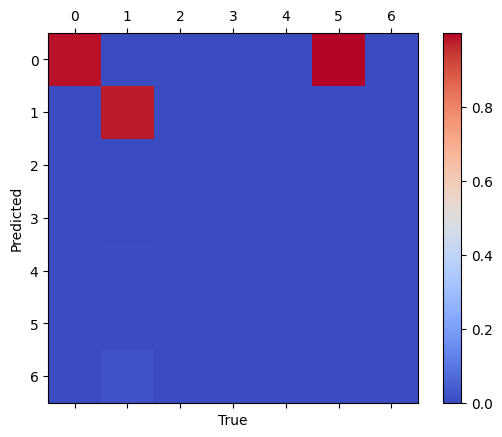

In [126]:
plot_confusion(matrix)

#### Pela matriz de confusão, podemos ver que o classificador falha em classificar os dados que nao sejam da classe 0 ou 1. Assim, não temos um classificador útil

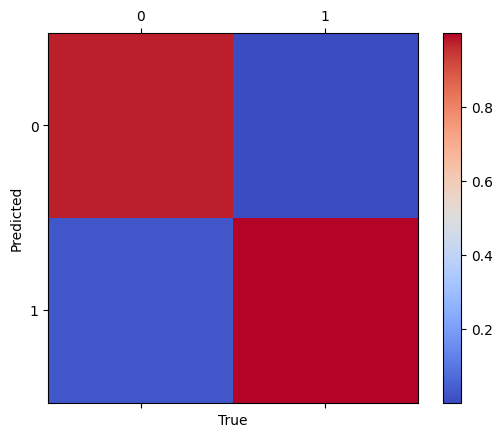

In [127]:
plot_confusion(binary)

#### Aqui, a matriz de positivos e negativos (TP, FP, FN, TN) não é muito útil, pois uma das classes, a classe 1, que é dado de ataque, como é majoritária, obfusca a performance do classificador em outras classes de ataque. Então veremos os dados "crus".

In [128]:
binary

tensor([[13180,     4],
        [  359,  7739]], device='cuda:0')

In [171]:
print(torch.sum(matrix[2:, :-2].diagonal())) # Soma dos acertos de cada classe

tensor(10, device='cuda:0')


#### Utilizando os dados não balanceados, acertamos apenas 1 dos 357 dados raros!

## Obtido as métricas do treino anterior, faremos agora a geração de novos dados sintéticos para treinarmos o nosso novo classificador, e esperamos que os resultados sejam melhores

In [244]:
# vamos utilizar a TMG GAN para gerar dados sintéticos
dataloader = enhance_train_data()

0.0
0.14285714285714285
0.2857142857142857
0.42857142857142855
0.5714285714285714
0.7142857142857143
0.8571428571428571


In [245]:
model_enhanced_tmg = fit_model(DiscriminatorClassifier(64, 1).to(device), dataloader, 1)
matrix_tmg, binary_tmg, ytrue, ypred = test_val(model_enhanced_tmg, te_dataloader)
print_metrics(binary_tmg)

Accuracy: 0.9907433390617371
Average Loss: 0.11222375930474326
Precision: 0.9871708154678345
Recall: 0.9980279207229614
F1: tensor(0.9926, device='cuda:0')


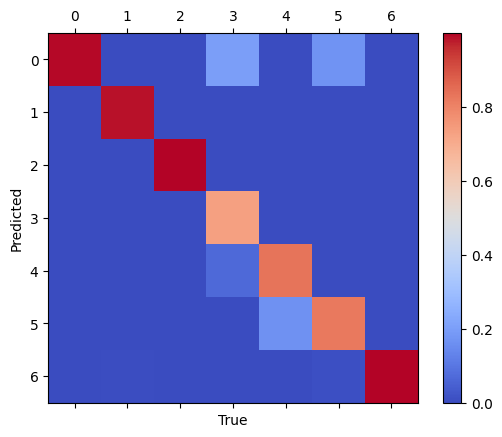

In [246]:
plot_confusion(matrix_tmg)

#### Como podemos ver, surge uma diagonal na matriz de confusão, o modelo passa a classificar os dados que não sejam apenas da classe 0 e 1.

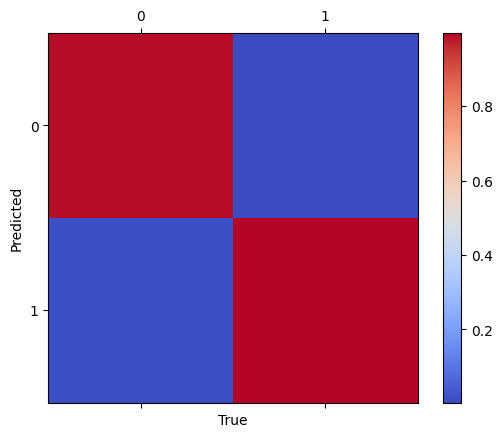

In [247]:
plot_confusion(binary_tmg)

#### Aqui, a visualização da matriz de positivos e negativos também não é muito útil. Veremos portanto, os dados crus

In [248]:
binary_tmg

tensor([[13158,    26],
        [  171,  7927]], device='cuda:0')

In [254]:
print(torch.sum(matrix_tmg[2:, :-2].diagonal())) # soma dos acertos das classes raras

tensor(183, device='cuda:0')

#### Conseguimos classificar 183 dados de ataque que antes não tínhamos conseguido. Pode não parecer muito, mas 183 representa 51% dos dados raros!

# Trabalhos relacionados: outros métodos de data enhancing

### SMOTE E SNGAN

## SMOTE. Balancearemos o dataset com o método SMOTE. Primeiro, geramos novos dados com o SMOTE, em seguida, treinamos o classificador com esses dados.

In [100]:
import imblearn
import imblearn.over_sampling as o_s


In [101]:
smote = o_s.SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(Xtr_normal,Ytr)

In [102]:
adasyn_data = DataLoader(TensorDataset(torch.tensor(X_res), torch.tensor(y_res)), batch_size=64, shuffle=True)

In [103]:
def train_ada(model, epochs, batch_size, optimizer, criterion, loader):
  lossi = []
  for epoch in range(epochs):
    for iter, data in enumerate(loader):
        X, y = data
        optimizer.zero_grad()
        outputs = model(X.unsqueeze(1).to(device))
        loss = criterion(outputs[1].squeeze(1), y.to(torch.int64).to(device))
        loss.backward();
        lossi.append(loss.item());
        optimizer.step();

  print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
  return lossi

In [104]:
model_smote = fit_model(DiscriminatorClassifier(64, 1).to(device), adasyn_data, 1)
matrix_smote, binary_smote, ytrue_smote, ypred_smote= test_val(model_smote, loader=te_dataloader)
print_metrics(binary_smote)

Accuracy: 0.9614228010177612
Average Loss: 0.26008118787506324
Precision: 0.9942432045936584
Recall: 0.9431887269020081
F1: tensor(0.9680, device='cuda:0')


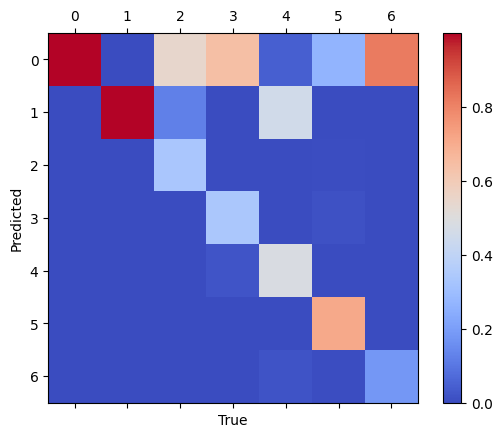

In [138]:
plot_confusion(matrix_smote)

#### Podemos ver pela matriz de confusão que, em comparação à da TMG GAN, está bem pior. Não há uma diagonal definida, e o classificador classifica vários dados normais como dados de ataque.

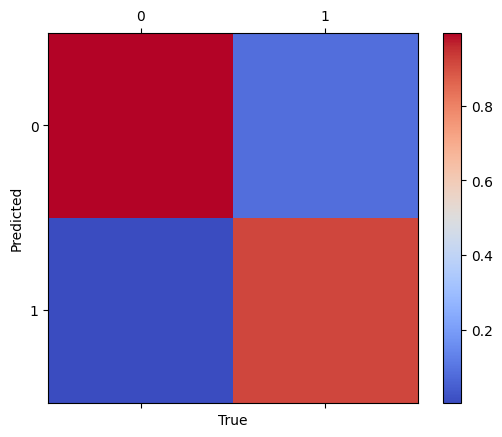

In [139]:
plot_confusion(binary_smote)

#### Aqui já é possivel ver que a diagonal esta menos definida do que antes

In [140]:
binary_smote

tensor([[12435,   749],
        [   72,  8026]], device='cuda:0')

In [251]:
print(torch.sum(matrix_smote[2:, :-2].diagonal())) # soma dos acertos das classes raras

tensor(2, device='cuda:0')


#### Conseguimos classificar corretamente mais dados de ataque do que antes, porém nossa taxa de falso positivos aumentou consideravelmente.

## SNGAN (não é preciso rodar essa parte do código, pois não foi utilizada no relatório. Não tivemos tempo para comparar com a SNGAN)
Utilizaremos o mesmo Critic e Gerador da TMG-GAN

In [ ]:
def init_weights(layer: nn.Module):
    if type(layer) == nn.Conv1d:
        nn.init.normal_(layer.weight, 0.0, 0.02)
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)
    elif type(layer) == nn.BatchNorm1d:
        nn.init.normal_(layer.weight, 1.0, 0.02)
        nn.init.constant_(layer.bias, 0)

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.relu = nn.ReLU()
    self.dropout1 = nn.Dropout(0.2)
    self.dropout2 = nn.Dropout(0.2)
    self.dropout3 = nn.Dropout(0.2)
    self.dropout4 = nn.Dropout(0.2)
    self.conv1 = nn.ConvTranspose1d(256, 128, 3, 1, 1)
    self.conv2 = nn.ConvTranspose1d(128, 256, 3, 1, 1)
    self.conv3 = nn.ConvTranspose1d(256, 512, 3, 1, 1)
    self.conv4 = nn.ConvTranspose1d(512, 117, 3, 1, 1)
    self.sigmoid = nn.ReLU()
    self.hidden_status = None
  def forward(self, x):
    x = self.relu(self.dropout1(self.conv1(x)))
    x = self.relu(self.dropout2(self.conv2(x)))
    x = self.relu(self.dropout3(self.conv3(x)))
    x = self.relu(self.dropout4(self.conv4(x)))
    self.hidden_status = x
    return self.sigmoid(x)

  def generate_samples(self, num: int) -> torch.Tensor:
    z = torch.randn(num, 256, 1, device=device)
    return self.forward(z).squeeze(-1).unsqueeze(1)


class DiscriminatorClassifier(nn.Module):
    def __init__(self, ndf, nc):
        super(DiscriminatorClassifier, self).__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv1d(nc, ndf, 9, 3, 0, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv1d(ndf, ndf*2, 6, 3, 0, bias=False)),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(ndf*2, ndf*2, 6, 1, 0, bias=False)),
            nn.Dropout(0.2),
        )
        self.leaky = nn.LeakyReLU(0.2, inplace=False)
        self.dfc =  nn.Sequential(
            spectral_norm(nn.Conv1d(ndf*2, ndf, 3, 1, 0, bias=False))
        )
        self.cfc = nn.Sequential(
            spectral_norm(nn.Conv1d(ndf*2, ndf, 3, 1, 0, bias=False))
        )
        self.l1 = spectral_norm(nn.Linear(768, 1))
        self.l2 = spectral_norm(nn.Linear(768, 8))
        self.apply(init_weights)
        self.hidden_status = None

    def forward(self, input):
        x = self.main(input)
        self.hidden_status = x
        x1 = self.leaky(self.dfc(x))
        x2 = self.leaky(self.cfc(x).squeeze(-1))
        x1 = x.view(x.shape[0], -1)
        x2 = x.view(x.shape[0], -1)
        return self.l1(x1), self.l2(x2)

In [ ]:
g = Generator().to(device)
d = DiscriminatorClassifier(1, 64).to(device)

In [ ]:
# treinar discriminador e classificador
opt_d = torch.optim.Adam( d.parameters(), lr=2e-4,)
opt_g = torch.optim.Adam( g.parameters(), lr=2e-4,)
for i, data in enumerate(tr_dataloader):
  X, y = data
  X = X.to(device)
  y = y.to(device)
  for _ in range(5):
      opt_d.zero_grad()
      score_real = d(X.unsqueeze(-1))[0].mean()
      generated_samples = g.generate_samples(64)
      score_generated = d(generated_samples)[0].mean()
      d_loss = (score_generated - score_real) / 2
      d_loss.backward()
      opt_d.step()
  # treinar gerador
  opt_g.zero_grad()
  generated_samples = g.generate_samples(64)
  score_generated = d(generated_samples)[0].mean()
  g_loss = -score_generated
  g_loss.backward()
  g_opt.step()


In [ ]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


error: remote origin already exists.
